# ASHRAE - Great Energy Predictor III
#### This project is based on a Kaggle competition with data provided by ASHRAE (American Society of Heating and Air-Conditioning Engineers). 


This project aims to answer the following questions:
1. Which type of buildings consume the most energy?
2. Which form of energy is consumed the most? 
3. Predict energy usage `meter_reading`.
4. Identify buildings which use more energy than most others (> quantile 0.75)

Note: some conversion is required.
```
"Due to a miscommunication, the electric meter readings for site 0 were not properly converted to units of kWh and are in kBTU. We apologize for the error and the resulting inconvenience.

The units of the electric meter readings for site 0 will not be updated (i.e., they will remain as is), since this could potentially disrupt the workflows and models of many teams. For models that are sensitive to units/absolute values, the issue can be avoided with the right conversion factors. Multiply by 0.2931 to get to model inputs into kWh like the other sites, and 3.4118 to get back to kBTU for scoring."
```

In [365]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.graph_objects as go

from datetime import datetime
from dateutil import parser

# format float in pandas
pd.options.display.float_format = '{:.4f}'.format
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50
pd.options.display.width = 100

In [366]:
# print(plt.style.available)
# plt.style.library['fivethirtyeight']

plt.style.use('seaborn-white')
rcParams['axes.labelsize'] = 'x-large'
rcParams['axes.edgecolor'] = 'black'
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlesize'] = 'x-large'
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.xmargin'] = 0.02
rcParams['axes.ymargin'] = 0.02
            
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = ':'
rcParams['grid.alpha'] = 0.2
rcParams['grid.color'] = 'black'
          
rcParams['figure.titlesize'] = 'x-large'
rcParams['figure.edgecolor']= 'black'
rcParams['figure.facecolor'] = 'white'
rcParams['figure.figsize'] = [12, 8]

rcParams['ytick.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 'large'

In [367]:
# Load data
train_df = pd.read_csv('../data/train.csv')
# test_df = pd.read_csv('../data/test.csv')
building_df = pd.read_csv('../data/building_metadata.csv')
weather_df = pd.read_csv('../data/weather_train.csv')
# weather_test_df = pd.read_csv('../data/weather_test.csv')


In [368]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [369]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [370]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [371]:
# CHECK DUPLICATES
building_df.duplicated(subset='building_id').any()

False

In [372]:
def nan_val_summary(df):
    """Summarize the counts of missing values"""
    nan_arr = np.count_nonzero(df.isnull(), axis=0)
    frac = nan_arr / df.shape[0]
    nan_df = pd.DataFrame(
        {'columns': df.columns,
         'nan_count': nan_arr,
         'fraction_missing': frac}
                 )
    return nan_df

def to_category(df, cols):
    """
    Iterates over `cols` and convert specified columns' 
    dtype to `category`.
    
    Params:
    --------
        cols: list of strings
              Name of columns from a DataFrame
    Returns:
    --------
        None
    
    """
    for item in cols:
        df[item] = df[item].astype('category')
        
def convert_dtype(df):
    """
    Convert data type of each column to reduce memory usage.
    """
    cols = df.columns.values
    data_types = ('int', 'float')
    
    # iterate over each column
    for col in cols:
        # convert integers
        if data_types[0] in str(df[col].dtype):
            df[col] = df[col].astype(np.int32)
        if data_types[1] in str(df[col].dtype):
            df[col] = df[col].astype(np.float32)
    return df

In [373]:
# convert dtype, this reduces memory usage
train_df = convert_dtype(train_df)
weather_df = convert_dtype(weather_df)
building_df = convert_dtype(building_df)

In [374]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int32
building_id    1449 non-null int32
primary_use    1449 non-null object
square_feet    1449 non-null int32
year_built     675 non-null float32
floor_count    355 non-null float32
dtypes: float32(2), int32(3), object(1)
memory usage: 39.7+ KB


# Datetime Conversion

In [375]:
dt_format = "%Y-%m-%d %H:%M:%S"
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], format=dt_format)
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], format=dt_format)

# Visuals: Buildings Data
Let's explore the types of buildings that are present in this data set.

In [376]:
building_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0000,nan
1,0,1,Education,2720,2004.0000,nan
2,0,2,Education,5376,1991.0000,nan
3,0,3,Education,23685,2002.0000,nan
4,0,4,Education,116607,1975.0000,nan


In [377]:
building_df['primary_use'].value_counts()

Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: primary_use, dtype: int64

In [378]:
def plot_bar(x, y, title='', x_axis='', y_axis='', **kwargs):
    """
    Plotly Bar graph.
    """
    fig = go.Figure(
        data=[go.Bar(x=x,
                     y=y)]
    )
    # update title and axis
    fig.update_layout(
        title_text = title,
        xaxis_title_text = x_axis,
        yaxis_title_text = y_axis,
        bargap=0.05,
        **kwargs
    )
    return fig.show()


# barplot settings
# barplot_settings = {'width': 1,
#                     'edgecolor': 'k',
#                     'color': color[2]
#                    }

# matplotlib bar plot
def bar_plot(x, y, title='', x_label='', y_label='', fig_size=(16, 8), **kwargs):
    """Simple bar plot using Seaborn"""
    
    plt.figure(figsize=fig_size)
    sns.barplot(x=x,
                y=y,
                color=color_pal[0],
                **kwargs
               )
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()

def barh_plot(y, x, title='', x_label='', y_label='', fig_size=(16, 8), **kwargs):
    """Horizontal simple bar plot"""

    plt.figure(figsize=fig_size)
    plt.barh(y, x, **kwargs)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()

def scatter_plot(x, y, title='', x_label='', y_label='', **kwargs):
    """Seaborn scatter plot"""
    sns.scatterplot(x, y, **kwargs)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    
    

In [379]:
x_use = building_df['primary_use'].value_counts().index.values
y_count = building_df['primary_use'].value_counts().values

# plot_bar(x_use,
#          y_count,
#          title='Building Type',
#          x_axis='Category',
#          y_axis='Count'
#         )

From the plot above, it may be a good idea to combine smaller categories into one. For example, combine all categories after "Lodging/residential" into a single category and name it "Others".

In [380]:
# year built
years = building_df['year_built'].dropna(how='any').astype(np.int16)
years = years.value_counts().sort_index()

# bar plot 
# year built
# plot_bar(x=years.index,
#          y=years.values,
#          title='Building Contruction Per Year',
#          x_axis='Years',
#          y_axis='Count')

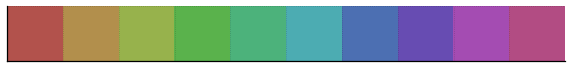

In [381]:
# color palette
color_pal = sns.hls_palette(10, l=.5, s=.4)
sns.palplot(color_pal)


## Building Type

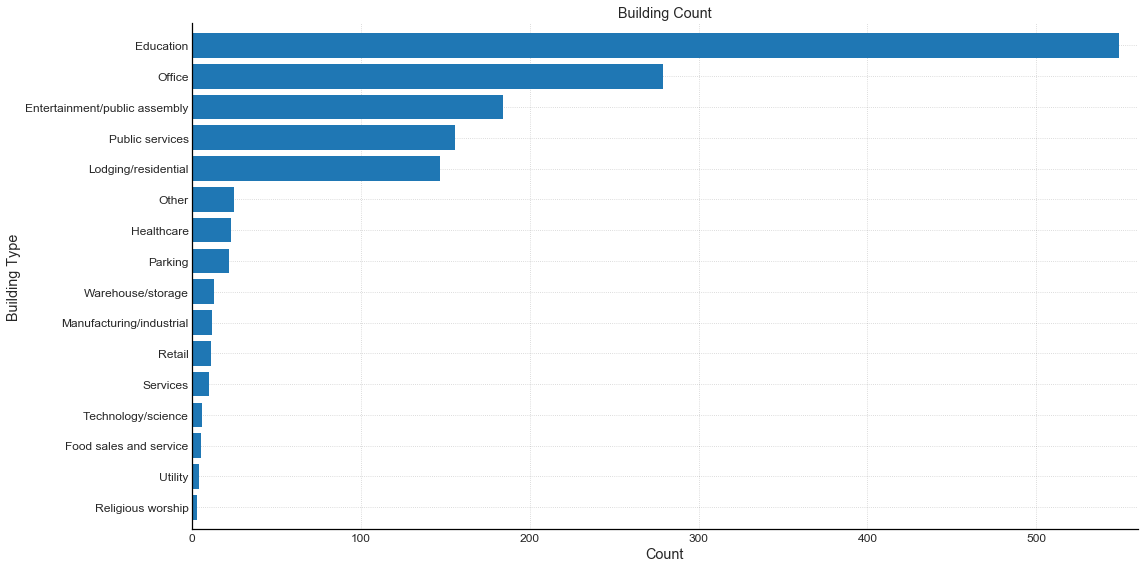

In [382]:
# extract building type into x and y
x_use = building_df['primary_use'].value_counts().sort_values().index.values
y_count = building_df['primary_use'].value_counts().sort_values().values

barh_plot(x_use,
          y_count,
         title='Building Count',
         y_label='Building Type',
         x_label='Count')

plt.show()

### Building Area (Ft$^2$)
Visualizing the distribution of the building's area we can see that it resembles an exponential distribution. The median area is about $57,673$ square feet which implies that 50% of the buildings in this data set are less than $57,673$ ft$^2$. 

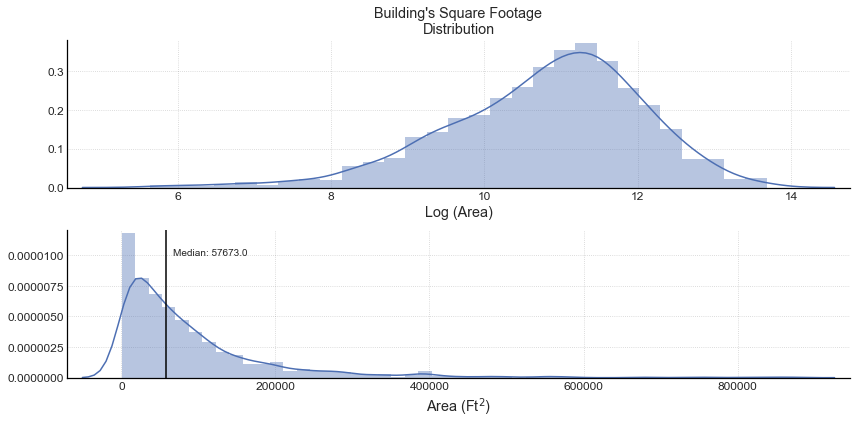

In [383]:
# BUILDING AREA (SQ. FT.) DISTRIBUTION
plt.subplots(1,2, figsize=(12, 6))

# compute (natural) log of area
sq_ft_log = np.log(building_df.square_feet.values)
# compute median to plot vertical line
sq_ft_median = np.median(building_df.square_feet.values)
# set color value
c=color_pal[6]

# Plot KDE Log of Area
plt.subplot(211)
sns.distplot(sq_ft_log, color=c)
plt.xlabel('Log (Area)')
plt.title("Building's Square Footage\nDistribution")

# Plot KDE Area
plt.subplot(212)
sns.distplot(building_df.square_feet.values, color=c)
plt.xlabel('Area (Ft$^2$)')
# plot median value, and annotate
plt.axvline(x=sq_ft_median, color='k')
plt.text(x=sq_ft_median+10000, s=f'Median: {sq_ft_median}', y=0.000010)

plt.tight_layout()
plt.show()

## Construction
Visualizing construction date.

In [520]:
building_df['year_built'].value_counts()
# building_df['year_built'].unique()

1976.0000    55
1966.0000    23
1968.0000    18
1919.0000    17
1964.0000    15
             ..
1934.0000     1
1936.0000     1
1926.0000     1
2017.0000     1
1947.0000     1
Name: year_built, Length: 116, dtype: int64

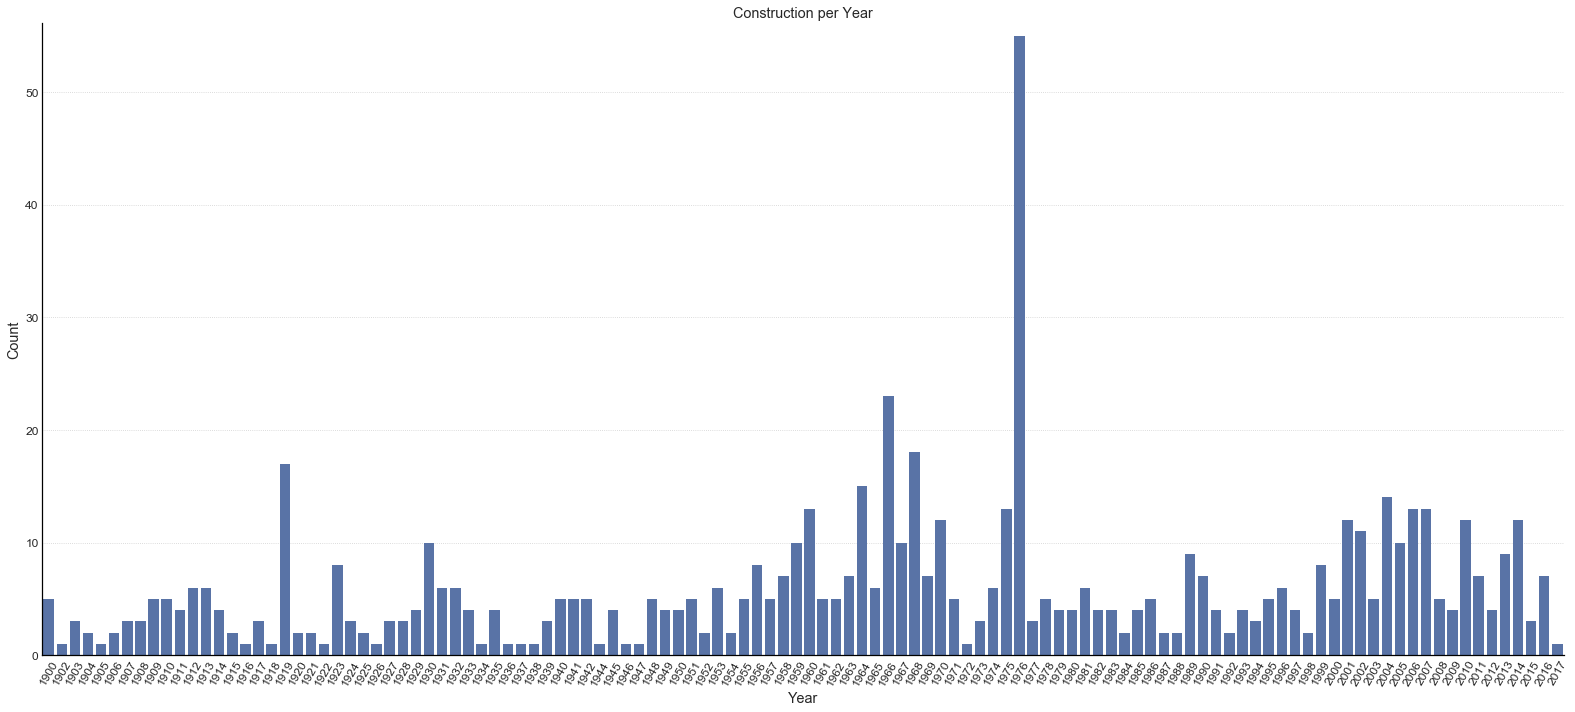

In [384]:
# CONSTRUCTION PER YEAR
x = np.uint32(building_df['year_built'].value_counts().index.values)

# plt.show()
plt.figure(figsize=(22, 10))
sns.barplot(x=x,
            y=building_df['year_built'].value_counts().values,
            color=c,
           )
plt.xticks(rotation=60)
plt.xlabel('Year')
plt.title('Construction per Year')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [385]:
building_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0000,nan
1,0,1,Education,2720,2004.0000,nan
2,0,2,Education,5376,1991.0000,nan
3,0,3,Education,23685,2002.0000,nan
4,0,4,Education,116607,1975.0000,nan


## Building Type and Area

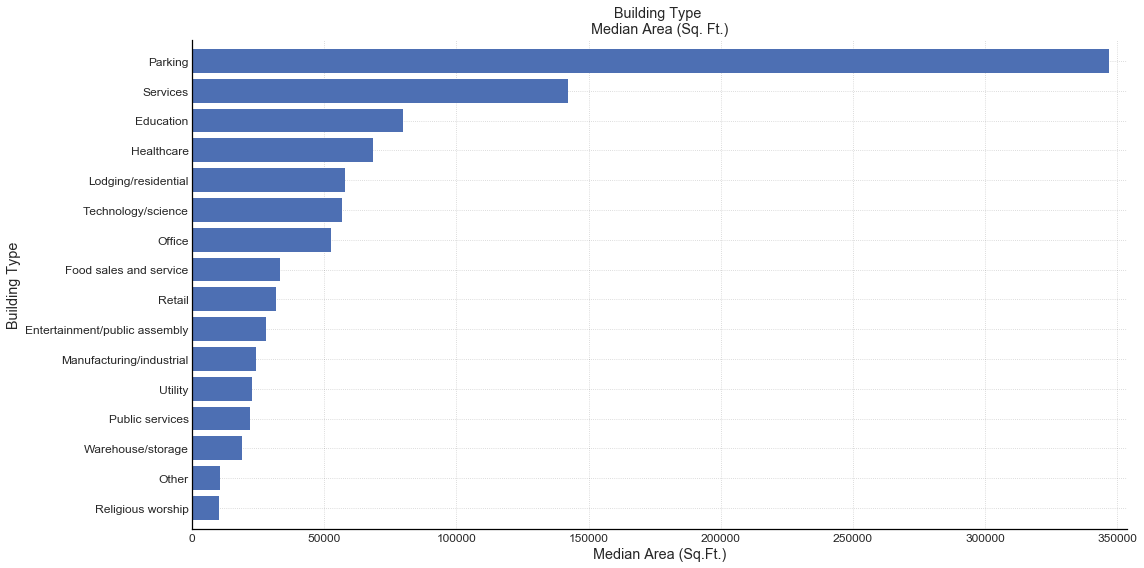

In [386]:
bldg_use_area = building_df.groupby(['primary_use'])['square_feet'].median()
x=bldg_use_area.sort_values().index.tolist()
y=bldg_use_area.sort_values()

# horizontal barplot
barh_plot(x, 
          y, 
          title='Building Type \nMedian Area (Sq. Ft.)',
          x_label='Median Area (Sq.Ft.)',
          y_label='Building Type',
          color=c
         )
plt.show()


## Weather 

In [393]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int32
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float32
cloud_coverage        70600 non-null float32
dew_temperature       139660 non-null float32
precip_depth_1_hr     89484 non-null float32
sea_level_pressure    129155 non-null float32
wind_direction        133505 non-null float32
wind_speed            139469 non-null float32
dtypes: datetime64[ns](1), float32(7), int32(1)
memory usage: 5.3 MB


In [394]:
weather_df.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.0000,139718.0000,70600.0000,139660.0000,89484.0000,129155.0000,133505.0000,139469.0000
mean,7.4790,14.4181,2.1493,7.3501,0.9830,1016.1586,180.5266,3.5579
std,4.6047,10.6267,2.5995,9.7909,8.4653,7.6296,111.5385,2.3360
min,0.0000,-28.9000,0.0000,-35.0000,-1.0000,968.2000,0.0000,0.0000
25%,3.0000,7.2000,0.0000,0.6000,0.0000,1011.8000,80.0000,2.1000
50%,7.0000,15.0000,2.0000,8.3000,0.0000,1016.4000,190.0000,3.1000
75%,11.0000,22.2000,4.0000,14.4000,0.0000,1020.8000,280.0000,5.0000
max,15.0000,47.2000,9.0000,26.1000,343.0000,1045.5000,360.0000,19.0000


## Missing Values: Weather Data

In [396]:
def get_nan_idx(column, df=weather_df):
    """
    Returns the indices of missing values in given 
    column and DataFrame.
    """
    return df[df[column].isna()].index.values 

def get_nan_columns(df):
    """
    Extract name of columns which have missing values.
    """
    df = nan_val_summary(df)
    return df[df['fraction_missing'] > 0]['columns'].values


In [411]:
def fill_weather_nans(column, df=weather_df, agg_func='median'):
    """
    Fills in missing values in Weather data. Column name must be provided.
    Function fills missing values inplace and therefore returns nothing.
    
    Uses the following method to fill NaNs:
        1. Groupby three variables, `site_id`, `month`, and `day`
        2. Compute `agg_func`, this will be used to fill missing values
        3. Check for missing values in aggregated data
            - If missing values present
                - Use interpolation to fill those missing values
        4. Set index of DataFrame `df`  such that it matches the aggregated 
        DataFrame index
        5. Update DataFrame `df` and fill missing values
        6. Reset index of `df`
    
    Params:
    -------
        column: str
            Name of column to fill
            
    Returns:
    --------
        None
        DataFrame is updated inplace.
    """
    
    # new features: month, hour
    df['month'] = weather_df['timestamp'].dt.month
    df['hour'] = weather_df['timestamp'].dt.hour
    df['day'] = weather_df['timestamp'].dt.day
    
    # aggregate data to obtain median value for a particular site, month, and day
    agg_weather_df = pd.DataFrame(df.groupby(['site_id', 'month', 'day'])[column].agg(agg_func))
    
    # check for missing values in the aggregated data
    if agg_weather_df[column].isnull().any():
        # fill NaNs using interpolation
        agg_df = agg_weather_df[column].interpolate(limit_direction='both',
                                                    inplace=True)
        agg_weather_df.update(agg_df, overwrite=False)
        
    # set index before updating input DataFrame
    df.set_index(['site_id', 'month', 'day'], inplace=True)
    df.update(agg_weather_df, overwrite=False)
    
    # reset index
    df.reset_index(inplace=True)

In [395]:
nan_val_summary(weather_df)

,columns,nan_count,fraction_missing
0,site_id,0,0.0000
1,timestamp,0,0.0000
2,air_temperature,55,0.0004
3,cloud_coverage,69173,0.4949
4,dew_temperature,113,0.0008
5,precip_depth_1_hr,50289,0.3598
6,sea_level_pressure,10618,0.0760
7,wind_direction,6268,0.0448
8,wind_speed,304,0.0022


In [400]:
# new features: month, hour
weather_df['month'] = weather_df['timestamp'].dt.month
weather_df['hour'] = weather_df['timestamp'].dt.hour


In [413]:
nan_cols = get_nan_columns(weather_df)
[fill_weather_nans(col) for col in nan_cols]

[None, None, None, None, None, None, None]

In [414]:
nan_val_summary(weather_df)

,columns,nan_count,fraction_missing
0,site_id,0,0.0000
1,month,0,0.0000
2,day,0,0.0000
3,timestamp,0,0.0000
4,air_temperature,0,0.0000
5,cloud_coverage,0,0.0000
6,dew_temperature,0,0.0000
7,precip_depth_1_hr,0,0.0000
8,sea_level_pressure,0,0.0000
9,wind_direction,0,0.0000


## Meter

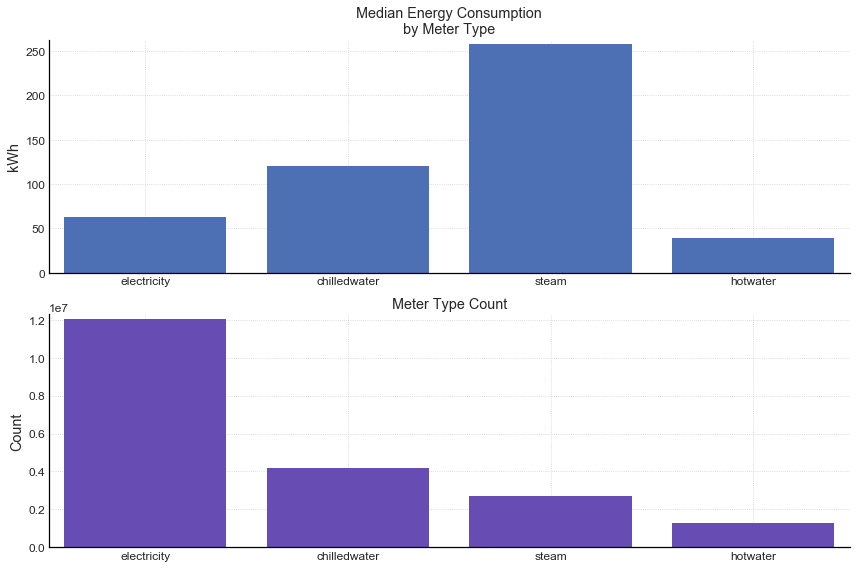

In [514]:
energy_use = train_df.groupby(['meter'])['meter_reading'].median()
meter_count = train_df['meter'].value_counts()
# PLOT: energy use and meter type count
plt.subplots(1,2, figsize=(12, 8))

# first subplot
plt.subplot(211)
bar1 = plt.bar(
    x=labels,
    height=energy_use.values,
    color=color_pal[6]
)
plt.title('Median Energy Consumption\nby Meter Type')
plt.ylabel('kWh')

# second subplot
plt.subplot(212)
bar2 = plt.bar(
    x=labels,
    height=meter_count.values,
    color=color_pal[7]
)
plt.title('Meter Type Count')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [533]:
meter_id = 0
meter_type_df = train_df[train_df['meter'] == meter_id][['meter_reading', 'timestamp']].set_index('timestamp')
meter_type_df = meter_type_df.resample('H').mean()

# meter_type_df.describe()

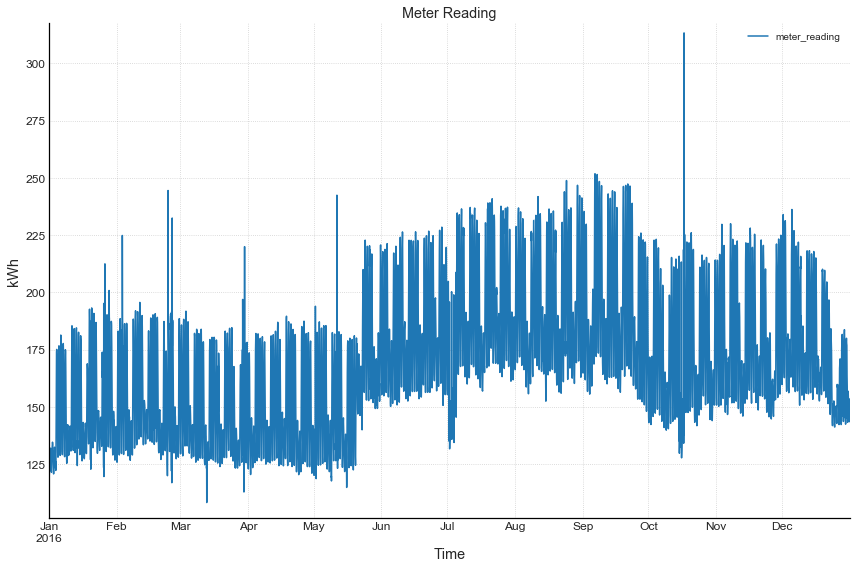

In [534]:
meter_type_df.plot(kind='line')
plt.title('Meter Reading')
plt.xlabel('Time')
plt.ylabel('kWh')

plt.tight_layout()
plt.show()

## Merge 

In [33]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0000
1,1,0,2016-01-01,0.0000
2,2,0,2016-01-01,0.0000
3,3,0,2016-01-01,0.0000
4,4,0,2016-01-01,0.0000


In [422]:
nan_val_summary(train_df)

,columns,nan_count,fraction_missing
0,building_id,0,0.0000
1,meter,0,0.0000
2,timestamp,0,0.0000
3,meter_reading,0,0.0000


In [34]:
tb_df = pd.merge(train_df, building_df, on='building_id')
trw_df = pd.merge(tb_df, weather_df, on=['site_id', 'timestamp'])


In [35]:
trw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20125605 entries, 0 to 20125604
Data columns (total 18 columns):
building_id           int32
meter                 int32
timestamp             datetime64[ns]
meter_reading         float32
site_id               int32
primary_use           object
square_feet           int32
year_built            float32
floor_count           float32
building_age          float32
flr_cnt_nan           int32
air_temperature       float32
cloud_coverage        float32
dew_temperature       float32
precip_depth_1_hr     float32
sea_level_pressure    float32
wind_direction        float32
wind_speed            float32
dtypes: datetime64[ns](1), float32(11), int32(5), object(1)
memory usage: 1.6+ GB


In [36]:
trw_df.drop('site_id', axis=1, inplace=True)

In [37]:
nan_val_summary(trw_df)

,columns,nan_count,fraction_missing
0,building_id,0,0.0000
1,meter,0,0.0000
2,timestamp,0,0.0000
3,meter_reading,0,0.0000
4,primary_use,0,0.0000
5,square_feet,0,0.0000
6,year_built,12113306,0.6019
7,floor_count,16630052,0.8263
8,building_age,12113306,0.6019
9,flr_cnt_nan,0,0.0000


In [38]:
trw_df.drop(['floor_count'], axis=1, inplace=True)

In [39]:
trw_df['year_built'].describe()

count   8012299.0000
mean       2039.0071
std          76.8278
min        1900.0000
25%        1951.0000
50%        1970.0000
75%        1993.0000
max        2017.0000
Name: year_built, dtype: float64

In [48]:
trw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20125605 entries, 0 to 20125604
Data columns (total 16 columns):
building_id           int32
meter                 category
timestamp             datetime64[ns]
meter_reading         float32
primary_use           category
square_feet           int32
year_built            float32
building_age          float32
flr_cnt_nan           int32
air_temperature       float32
cloud_coverage        float32
dew_temperature       float32
precip_depth_1_hr     float32
sea_level_pressure    float32
wind_direction        float32
wind_speed            float32
dtypes: category(2), datetime64[ns](1), float32(10), int32(3)
memory usage: 1.3 GB


In [41]:
to_category(trw_df, ['meter', 'primary_use'])

In [49]:
nan_val_summary(trw_df)

,columns,nan_count,fraction_missing
0,building_id,0,0.0000
1,meter,0,0.0000
2,timestamp,0,0.0000
3,meter_reading,0,0.0000
4,primary_use,0,0.0000
5,square_feet,0,0.0000
6,year_built,12113306,0.6019
7,building_age,12113306,0.6019
8,flr_cnt_nan,0,0.0000
9,air_temperature,6163,0.0003


In [44]:
trw_df.head()

,building_id,meter,timestamp,meter_reading,primary_use,square_feet,year_built,building_age,flr_cnt_nan,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0000,Education,7432,2008.0000,12.0000,1,25.0000,6.0000,20.0000,nan,1019.7000,0.0000,0.0000
1,1,0,2016-01-01,0.0000,Education,2720,2004.0000,16.0000,1,25.0000,6.0000,20.0000,nan,1019.7000,0.0000,0.0000
2,2,0,2016-01-01,0.0000,Education,5376,1991.0000,29.0000,1,25.0000,6.0000,20.0000,nan,1019.7000,0.0000,0.0000
3,3,0,2016-01-01,0.0000,Education,23685,2002.0000,18.0000,1,25.0000,6.0000,20.0000,nan,1019.7000,0.0000,0.0000
4,4,0,2016-01-01,0.0000,Education,116607,1975.0000,45.0000,1,25.0000,6.0000,20.0000,nan,1019.7000,0.0000,0.0000


In [54]:
trw_df.set_index('timestamp', inplace=True)

In [211]:
# {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

# select building
bldg_id = trw_df[trw_df['building_id'] == 1003]

# extract meter type
electric = bldg_id[bldg_id['meter'] == 0]
chw = bldg_id[bldg_id['meter'] == 1]
stm = bldg_id[bldg_id['meter'] == 2]
hw = bldg_id[bldg_id['meter'] == 3]
bldg_id['meter'].nunique()

In [214]:
electric['meter_reading'][45:75]

timestamp
2016-01-02 22:00:00   62.6300
2016-01-02 23:00:00   60.5000
2016-01-03 00:00:00   56.1200
2016-01-03 01:00:00   63.5001
2016-01-03 02:00:00   61.5001
2016-01-03 03:00:00   62.2500
2016-01-03 04:00:00   58.0000
2016-01-03 05:00:00   56.3800
2016-01-03 06:00:00   62.1201
2016-01-03 07:00:00   63.7500
2016-01-03 08:00:00   58.8800
2016-01-03 09:00:00   57.1200
2016-01-03 10:00:00   57.2500
2016-01-03 11:00:00   57.5000
2016-01-03 12:00:00   58.8800
2016-01-03 13:00:00   60.8700
2016-01-03 14:00:00   59.6300
2016-01-03 15:00:00   60.7500
2016-01-03 16:00:00   59.1200
2016-01-03 17:00:00   62.2500
2016-01-03 18:00:00   64.6300
2016-01-03 19:00:00   66.8700
2016-01-03 20:00:00   65.5000
2016-01-03 21:00:00   64.1300
2016-01-03 22:00:00   60.8701
2016-01-03 23:00:00   57.8801
2016-01-04 00:00:00   57.6200
2016-01-04 01:00:00   59.6300
2016-01-04 02:00:00   55.1201
2016-01-04 03:00:00   51.7500
Name: meter_reading, dtype: float32

In [215]:
electric['2016-01-01']['meter_reading'].index.hour.values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23], dtype=int64)

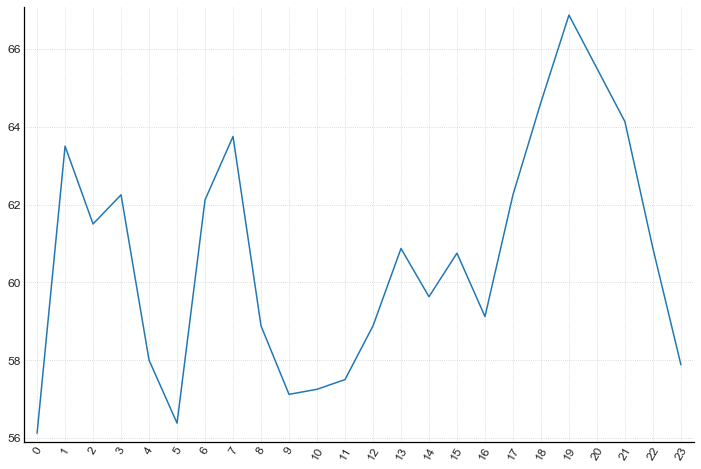

In [216]:
# electric['2016-01-01 00:00:00': '2016-01-01 23:00:00']['meter_reading'].plot.line()
# electric['2016-01-01 00:00:00': '2016-01-01 23:00:00']['meter_reading'].index.hour

plt.plot(electric['2016-01-03']['meter_reading'].values)
plt.xticks(ticks=electric['2016-01-03']['meter_reading'].index.hour.values,
          rotation=60)
plt.show()